# Visualize the PR curves and probability distribution for control cells to evaluate performance

## Import libraries

In [1]:
suppressPackageStartupMessages({
    library(ggplot2)
    library(tidyr)
    library(dplyr)
    library(arrow)
    library(ggridges)
    library(RColorBrewer)
})

Warning message:
“package ‘ggplot2’ was built under R version 4.2.3”
Warning message:
“package ‘tidyr’ was built under R version 4.2.3”
Warning message:
“package ‘arrow’ was built under R version 4.2.3”
Warning message:
“package ‘ggridges’ was built under R version 4.2.3”
Warning message:
“package ‘RColorBrewer’ was built under R version 4.2.3”


## Set plate to process and output figure directory

In [2]:
plate_to_process <- "redo_DMSO_plate"  # options: "original" or "redo"

output_dir <- file.path("figures", plate_to_process)
if (!dir.exists(output_dir)) {
    dir.create(output_dir, recursive = TRUE)
}

## Read in the PR curve results for binary logistic regressions

In [3]:
pr_results <- read_parquet(file.path("performance_metrics", plate_to_process, "all_models_pr_curve_results.parquet"))

head(pr_results)

precision,recall,model_type,dataset,model_name
<dbl>,<dbl>,<chr>,<chr>,<chr>
0.5000000,1,final,train,model_HCM
0.5002030,1,final,train,model_HCM
0.5004062,1,final,train,model_HCM
0.5006095,1,final,train,model_HCM
0.5008130,1,final,train,model_HCM
0.5010167,1,final,train,model_HCM


## Generate PR curves with the test and train data splits per trained model

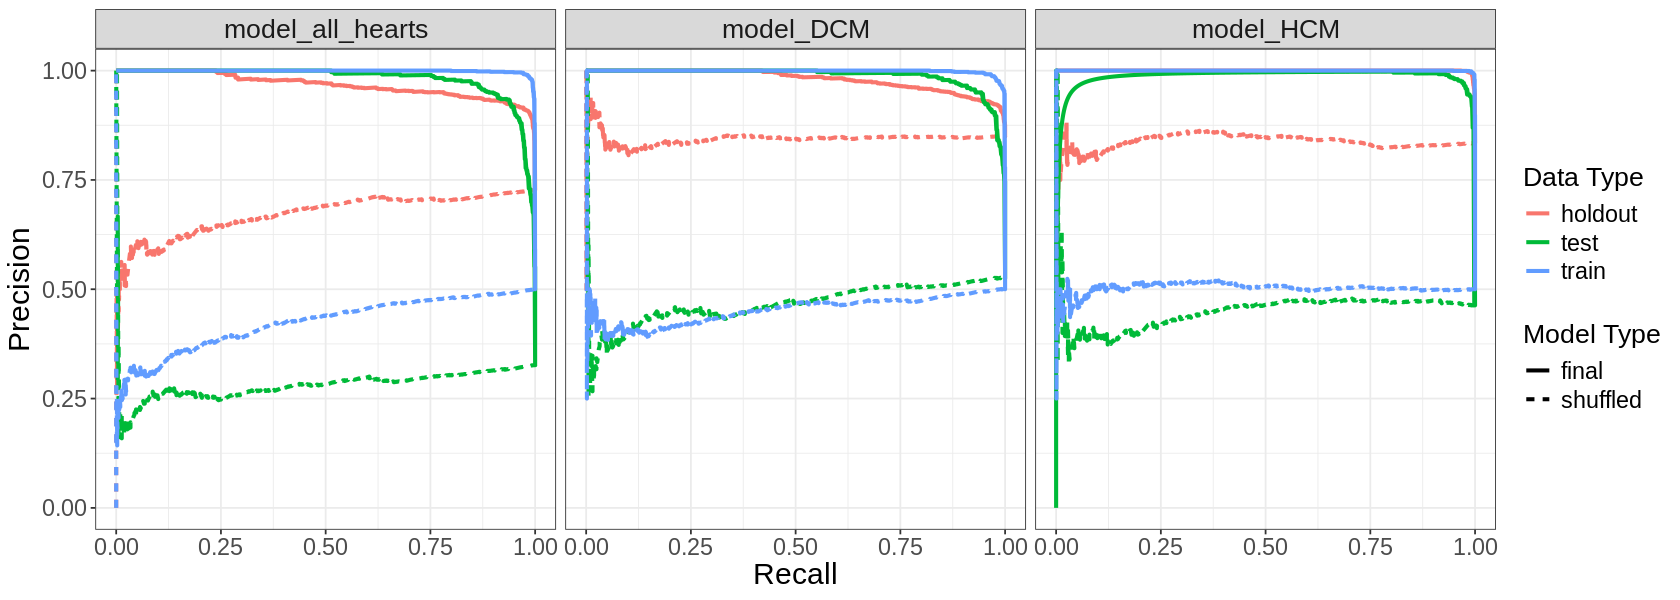

In [4]:
width = 14
height = 5
options(repr.plot.width = width, repr.plot.height = height)  # Adjust width and height as desired

# # Filter the data for Train and Test only
# filtered_data <- pr_results[pr_results$dataset %in% c("train", "test"), ]

# Create the ggplot for PR curves
all_models_pr_curves <- ggplot(pr_results, aes(x = recall, y = precision, color = dataset, linetype = model_type)) +
    geom_line(linewidth = 1.15) +
    facet_wrap(model_name ~ .) +
    labs(
        x = "Recall",
        y = "Precision",
        color = "Data Type",
        linetype = "Model Type"
    ) +
    theme_bw() +
    theme(
        text = element_text(size = 16),  # Increase font size for all text
        axis.title = element_text(size = 18),  # Increase font size for axis titles
        axis.text = element_text(size = 14),  # Increase font size for axis text
        legend.title = element_text(size = 16),  # Increase font size for legend title
        legend.text = element_text(size = 14),  # Increase font size for legend text
        strip.text = element_text(size = 16)  # Increase font size for facet labels
    )

# Save the plot to the output directory
ggsave(file.path(output_dir, "all_models_pr_curves.png"), all_models_pr_curves, dpi = 500, height = height, width = width)

all_models_pr_curves

## Generate a ridge plot per trained plate model with only the testing data to see if the probability distributions for the DMSO controls look correct

In [5]:
probability_results <- read_parquet(file.path("performance_metrics", plate_to_process, "all_models_predicted_probabilities.parquet"))

head(probability_results)

actual_label,predicted_probability,Metadata_treatment,Metadata_heart_number,model_type,dataset,model_name
<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
Failing,3.385278e-03,DMSO,46,final,train,model_HCM
Failing,4.024443e-03,DMSO,46,final,train,model_HCM
Failing,1.118317e-04,DMSO,46,final,train,model_HCM
Failing,1.225798e-01,DMSO,46,final,train,model_HCM
Failing,1.353488e-05,DMSO,46,final,train,model_HCM
Failing,1.957257e-04,DMSO,46,final,train,model_HCM


In [6]:
# Print unique Metadata_heart_number values and counts
unique_hearts <- sort(unique(probability_results$Metadata_heart_number))
cat("Unique Metadata_heart_number values (n =", length(unique_hearts), "):\n")
print(unique_hearts)

cat("\nCounts per Metadata_heart_number:\n")
print(table(probability_results$Metadata_heart_number))

Unique Metadata_heart_number values (n = 5 ):
[1]  2  7 23 25 46

Counts per Metadata_heart_number:

    2     7    23    25    46 
14858  4376  3330  2916  7496 


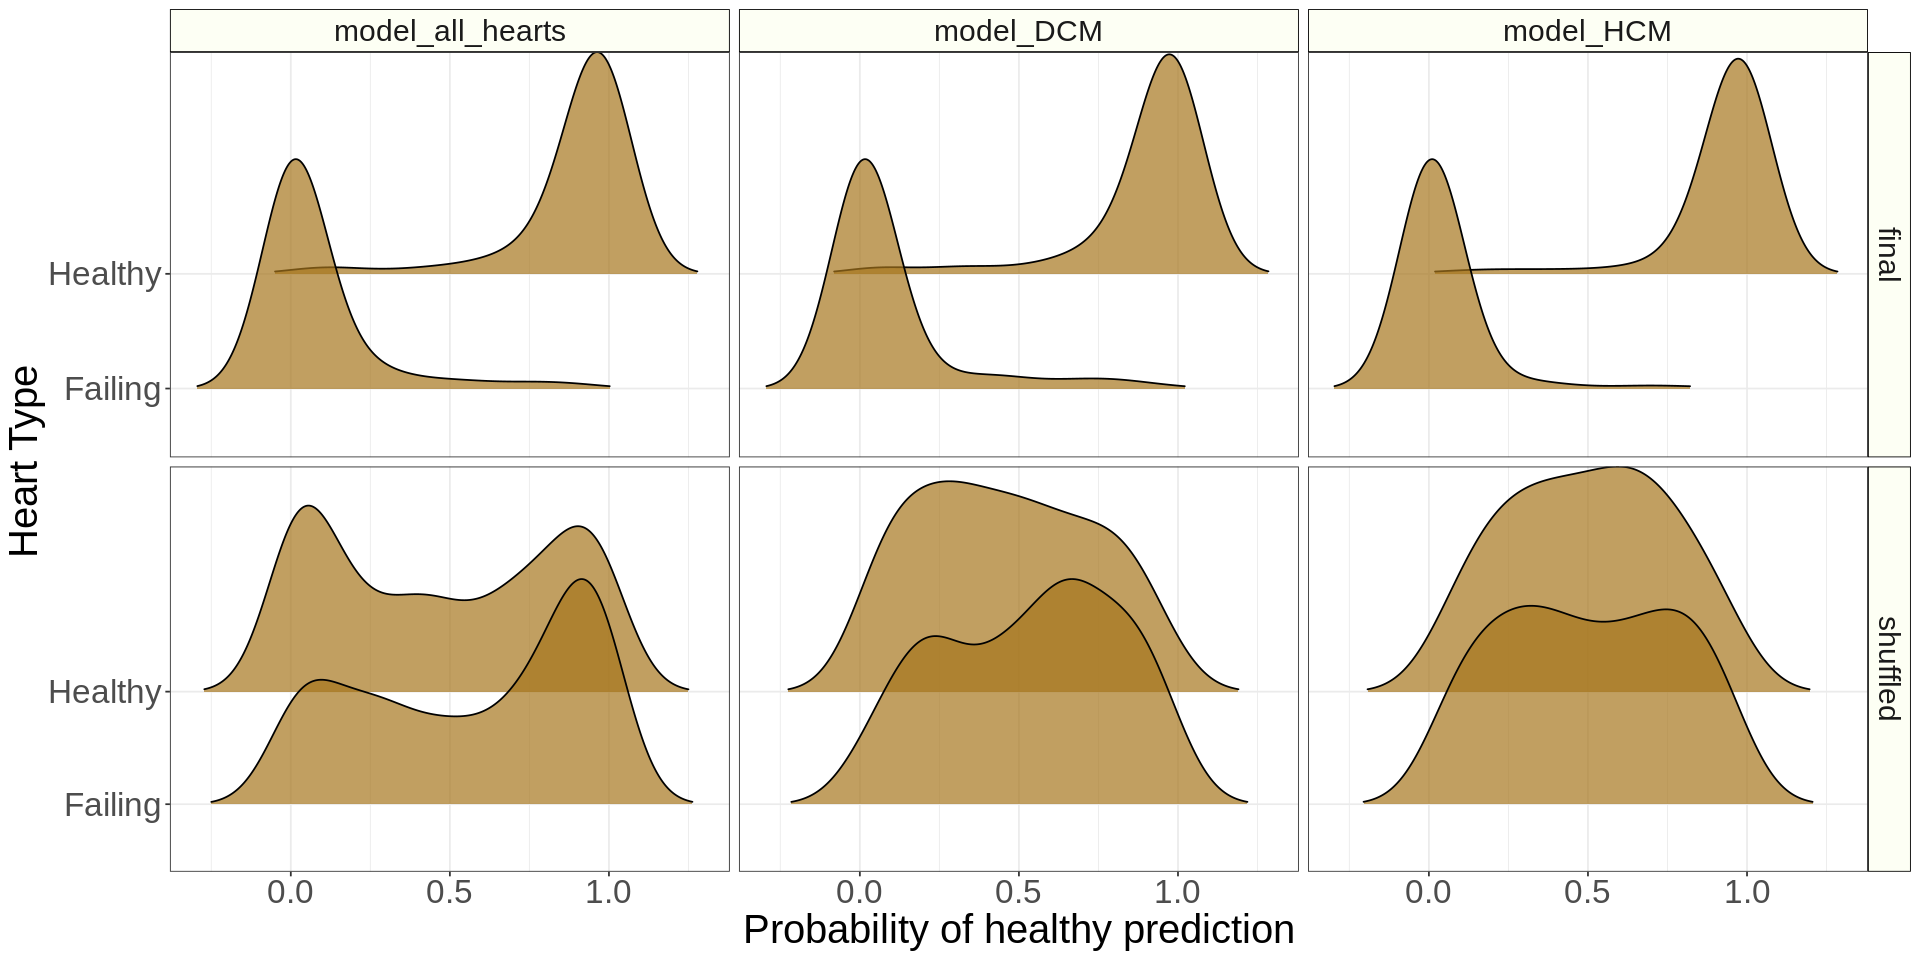

In [7]:
# Filter the data for test data only
test_performance_df <- probability_results[probability_results$dataset %in% c("test"), ]

height <- 8
width <- 16
options(repr.plot.width = width, repr.plot.height = height)

ridge_plot_test <- ggplot(test_performance_df, aes(x = predicted_probability, y = actual_label, fill = Metadata_treatment)) +
  geom_density_ridges(aes(fill = Metadata_treatment), alpha = 0.7, scale = 2, rel_min_height = 0.01, bandwidth = 0.1) +
  scale_fill_manual(values = c("DMSO" = brewer.pal(8, "Dark2")[7])) +  # Only include DMSO color
  scale_x_continuous(breaks = seq(0, 1, 0.5)) +
  facet_grid(model_type ~ model_name, scales = "free_y") + 
  labs(x = "Probability of healthy prediction", y = "Heart Type") +  # Update x-axis label
  theme_bw() +
  theme(
    legend.position = "none",
    axis.text = element_text(size = 20),
    axis.text.x = element_text(size = 20),
    axis.title = element_text(size = 24),
    strip.text = element_text(size = 18),
    strip.background = element_rect(
      colour = "black",
      fill = "#fdfff4"
    )
  )

# Save the plot to the output directory
ggsave(file.path(output_dir, "prob_ridge_plot_testing_data.png"), ridge_plot_test, dpi = 500, height = height, width = width)

ridge_plot_test

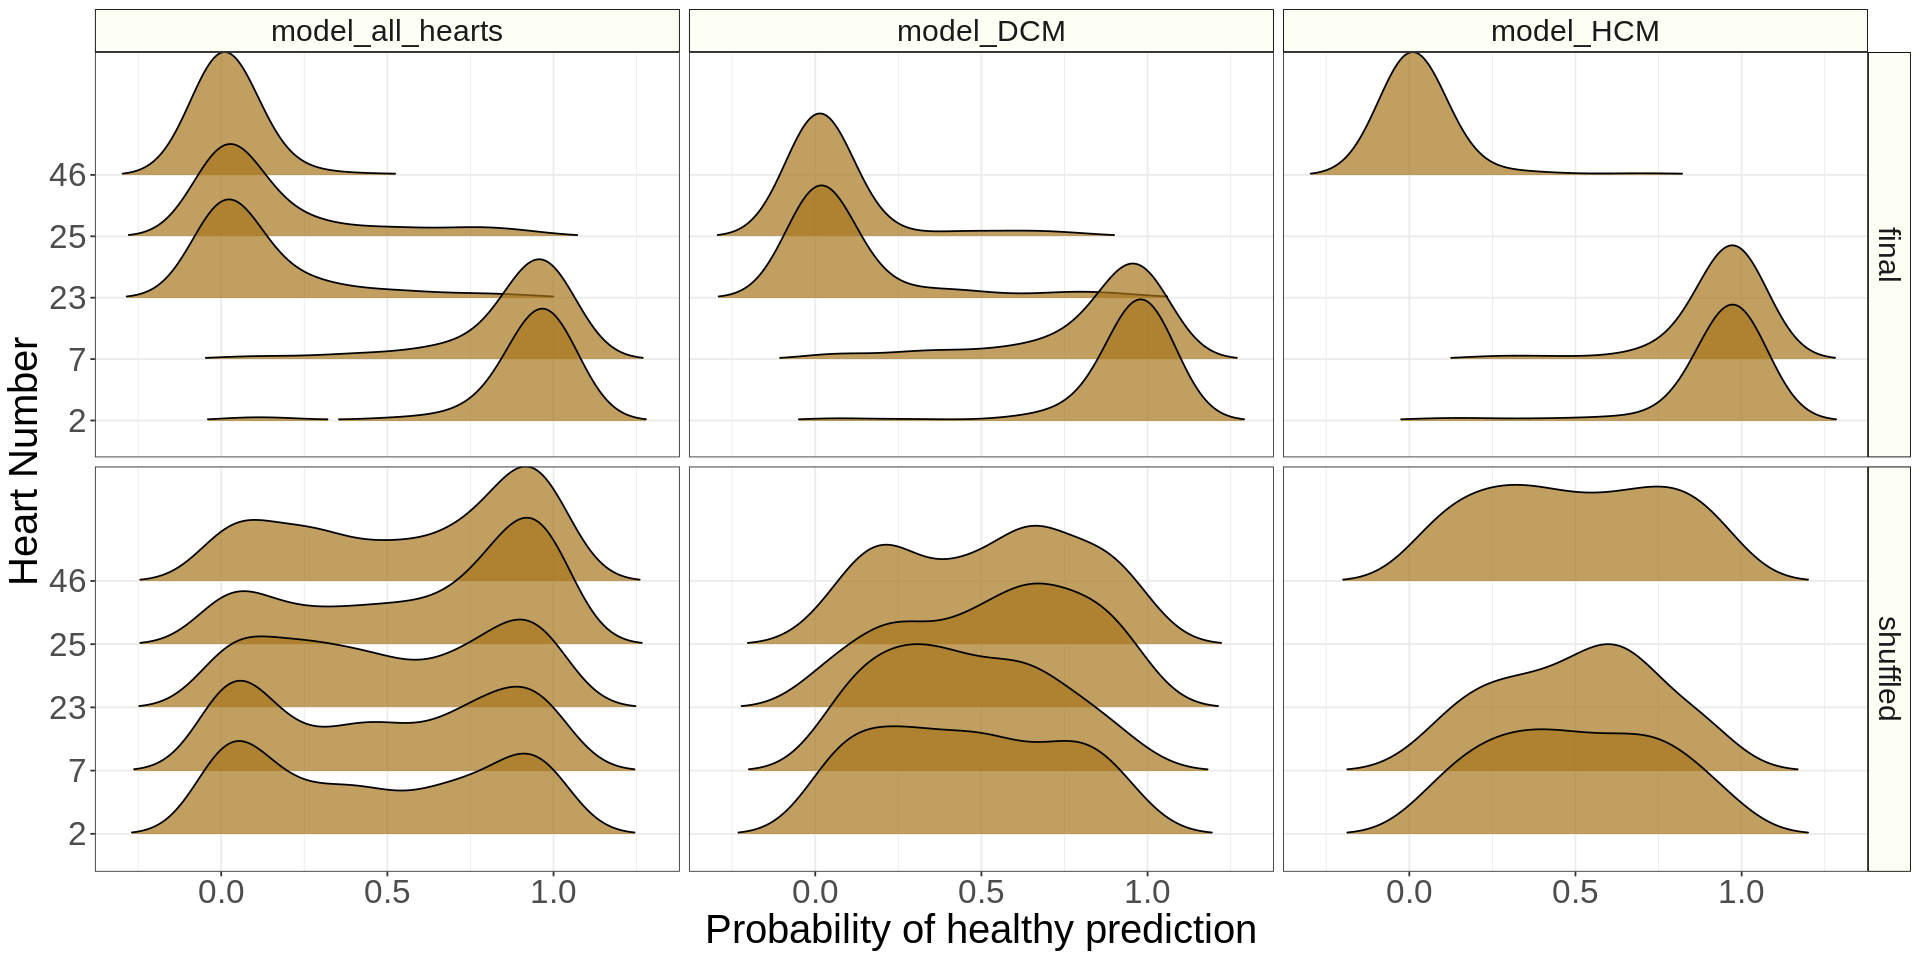

In [8]:
# Filter the data for test data only
test_performance_df <- probability_results[probability_results$dataset %in% c("test"), ]

height <- 8
width <- 16
options(repr.plot.width = width, repr.plot.height = height)

ridge_plot_test <- ggplot(test_performance_df, aes(x = predicted_probability, y = factor(Metadata_heart_number), fill = Metadata_treatment)) +
  geom_density_ridges(aes(fill = Metadata_treatment), alpha = 0.7, scale = 2, rel_min_height = 0.01, bandwidth = 0.1) +
  scale_fill_manual(values = c("DMSO" = brewer.pal(8, "Dark2")[7])) +  # Only include DMSO color
  scale_x_continuous(breaks = seq(0, 1, 0.5)) +
  facet_grid(model_type ~ model_name, scales = "free_y") + 
  labs(x = "Probability of healthy prediction", y = "Heart Number") +  # Updated y-axis label
  theme_bw() +
  theme(
    legend.position = "none",
    axis.text = element_text(size = 20),
    axis.text.x = element_text(size = 20),
    axis.title = element_text(size = 24),
    strip.text = element_text(size = 18),
    strip.background = element_rect(
      colour = "black",
      fill = "#fdfff4"
    )
  )

# Save the plot to the output directory
ggsave(file.path(output_dir, "prob_ridge_plot_per_heart_testing_data.png"), ridge_plot_test, dpi = 500, height = height, width = width)

ridge_plot_test


## Generate accuracy bar plots for binary logistic regressions

In [9]:
head(probability_results)

actual_label,predicted_probability,Metadata_treatment,Metadata_heart_number,model_type,dataset,model_name
<chr>,<dbl>,<chr>,<int>,<chr>,<chr>,<chr>
Failing,3.385278e-03,DMSO,46,final,train,model_HCM
Failing,4.024443e-03,DMSO,46,final,train,model_HCM
Failing,1.118317e-04,DMSO,46,final,train,model_HCM
Failing,1.225798e-01,DMSO,46,final,train,model_HCM
Failing,1.353488e-05,DMSO,46,final,train,model_HCM
Failing,1.957257e-04,DMSO,46,final,train,model_HCM


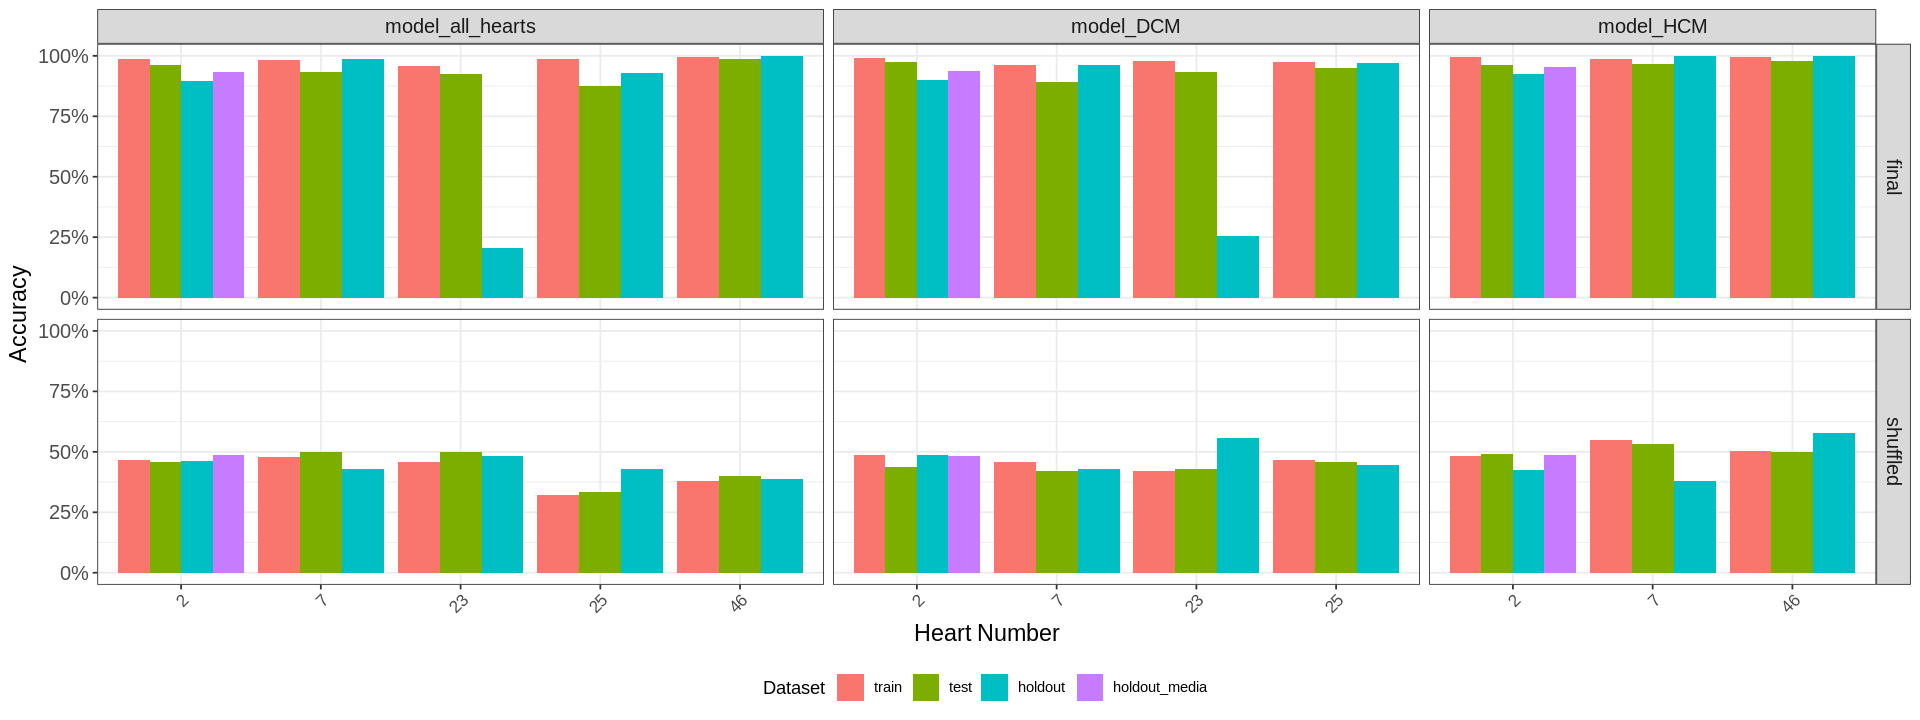

In [10]:
# Compute accuracy per heart, per split, per model
accuracy_per_heart <- probability_results %>%
    mutate(
    predicted_binary = ifelse(predicted_probability >= 0.5, 1L, 0L),
    actual_binary = as.integer(actual_label == "Healthy"),
    dataset_modified = case_when(
        Metadata_heart_number == 2 & dataset == "holdout" & Metadata_treatment == "None" ~ "holdout_media",
        TRUE ~ dataset
    )
) %>%
    group_by(model_name, model_type, dataset_modified, Metadata_heart_number, Metadata_treatment) %>%
    summarize(
        accuracy = mean(predicted_binary == actual_binary, na.rm = TRUE),
        n = n(),
        .groups = "drop"
    ) %>%
    # Ensure desired order for the dataset factor so bars appear in train, test, holdout, holdout_media order
    mutate(dataset_modified = factor(dataset_modified, levels = c("train", "test", "holdout", "holdout_media")))

# Plot accuracy per heart with modified dataset
height <- 6
width <- 16
options(repr.plot.width = width, repr.plot.height = height)

accuracy_barplot <- ggplot(
    accuracy_per_heart,
    aes(x = factor(Metadata_heart_number), y = accuracy, fill = dataset_modified)
) +
    geom_col(position = "dodge") +
    facet_grid(model_type ~ model_name, scales = "free_x", space = "free") +
    scale_y_continuous(labels = scales::percent_format(accuracy = 1), limits = c(0, 1)) +
    labs(
        x = "Heart Number",
        y = "Accuracy",
        fill = "Dataset"
    ) +
    theme_bw() +
    theme(
        axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
        axis.text.y = element_text(size = 12),
        axis.title = element_text(size = 14),
        strip.text = element_text(size = 12),
        legend.position = "bottom"
    )

# Save plot
ggsave(file.path(output_dir, "accuracy_per_heart_by_model.png"), accuracy_barplot, dpi = 600, width = width, height = height)

accuracy_barplot


## Generate PR curves and accuracy plots for multi-class model

In [11]:
# Load in PR curve results for multi-class model
multi_class_pr_results <- read_parquet(file.path("performance_metrics", plate_to_process, "multi_class_pr_results.parquet"))

head(multi_class_pr_results)

precision,recall,model_type,dataset,model_name,class_label
<dbl>,<dbl>,<chr>,<chr>,<chr>,<int>
0.2971898,1,final,train,model_all_hearts_multiclass,0
0.2972686,1,final,train,model_all_hearts_multiclass,0
0.2973475,1,final,train,model_all_hearts_multiclass,0
0.2974264,1,final,train,model_all_hearts_multiclass,0
0.2975053,1,final,train,model_all_hearts_multiclass,0
0.2975843,1,final,train,model_all_hearts_multiclass,0


In [12]:
# Define mapping from integer → string
class_label <- c("0" = "DCM", "1" = "HCM", "2" = "Healthy")

# Update multi_class_pr_results if it exists
if (exists("multi_class_pr_results") && "class_label" %in% names(multi_class_pr_results)) {
  multi_class_pr_results$class_label <- class_label[as.character(multi_class_pr_results$class_label)]
}

# Print if the mapping was successful
head(multi_class_pr_results)

precision,recall,model_type,dataset,model_name,class_label
<dbl>,<dbl>,<chr>,<chr>,<chr>,<chr>
0.2971898,1,final,train,model_all_hearts_multiclass,DCM
0.2972686,1,final,train,model_all_hearts_multiclass,DCM
0.2973475,1,final,train,model_all_hearts_multiclass,DCM
0.2974264,1,final,train,model_all_hearts_multiclass,DCM
0.2975053,1,final,train,model_all_hearts_multiclass,DCM
0.2975843,1,final,train,model_all_hearts_multiclass,DCM


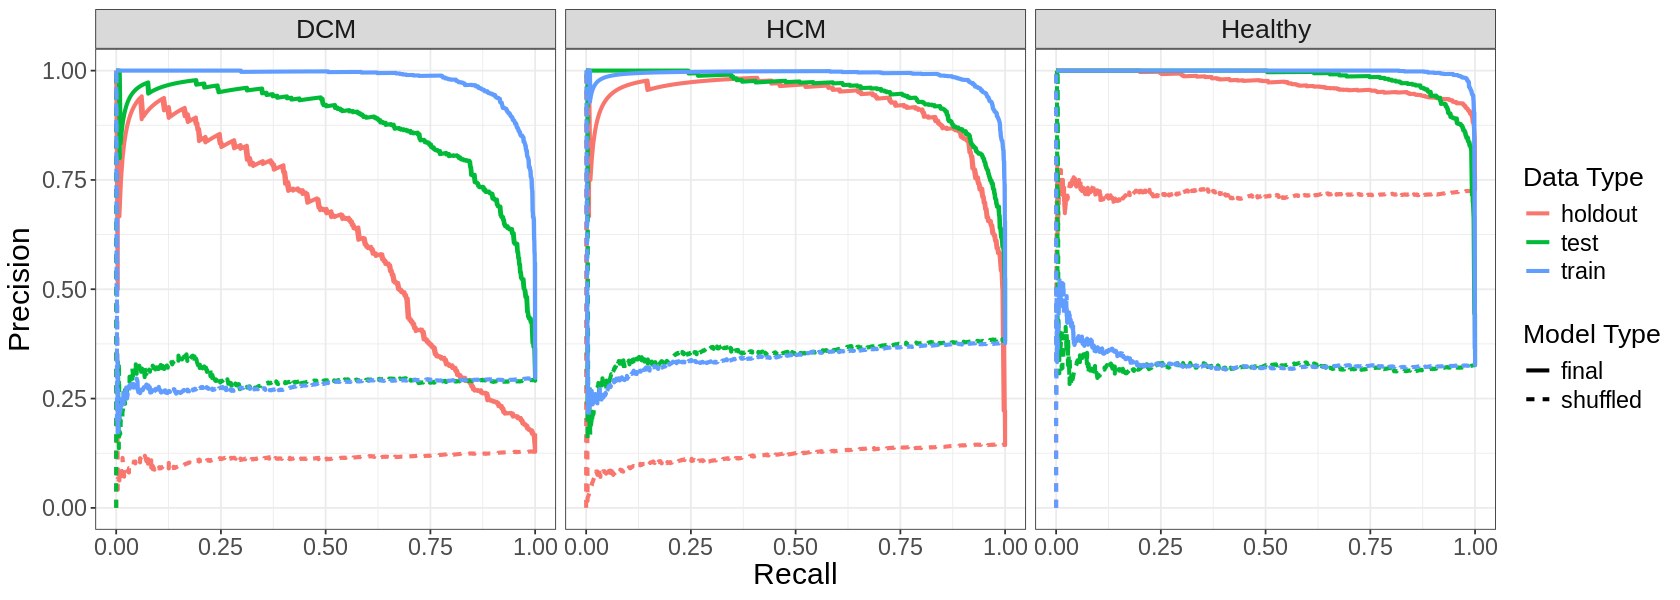

In [13]:
width = 14
height = 5
options(repr.plot.width = width, repr.plot.height = height)  # Adjust width and height as desired

# Create the ggplot for PR curves
multi_class_pr_results_plot <- ggplot(multi_class_pr_results, aes(x = recall, y = precision, color = dataset, linetype = model_type)) +
    geom_line(linewidth = 1.15) +
    facet_wrap(class_label ~ .) +
    labs(
        x = "Recall",
        y = "Precision",
        color = "Data Type",
        linetype = "Model Type"
    ) +
    theme_bw() +
    theme(
        text = element_text(size = 16),  # Increase font size for all text
        axis.title = element_text(size = 18),  # Increase font size for axis titles
        axis.text = element_text(size = 14),  # Increase font size for axis text
        legend.title = element_text(size = 16),  # Increase font size for legend title
        legend.text = element_text(size = 14),  # Increase font size for legend text
        strip.text = element_text(size = 16)  # Increase font size for facet labels
    )

# Save the plot to the output directory
ggsave(file.path(output_dir, "pr_curves_multiclass.png"), multi_class_pr_results_plot, dpi = 500, height = height, width = width)

multi_class_pr_results_plot

In [14]:
# Load in the accuracy results for multi-class model
multi_class_accuracy_results <- read_parquet(file.path("performance_metrics", plate_to_process, "multi_class_heart_accuracy.parquet"))

# Print the first few rows of the accuracy results
head(multi_class_accuracy_results)

dataset,model_type,model_name,heart_number,treatment,accuracy
<chr>,<chr>,<chr>,<int>,<chr>,<dbl>
train,final,model_all_hearts_multiclass,2,DMSO,0.9858065
train,final,model_all_hearts_multiclass,7,DMSO,0.9562363
train,final,model_all_hearts_multiclass,23,DMSO,0.9072000
train,final,model_all_hearts_multiclass,25,DMSO,0.9576613
train,final,model_all_hearts_multiclass,46,DMSO,0.9436223
train,final,model_all_hearts_multiclass,2,DMSO,0.9858065


In [15]:
# For heart_number 2: label as "holdout" if DMSO treated, "holdout_media" if None treatment; otherwise keep dataset
multi_class_accuracy_results <- multi_class_accuracy_results %>%
    mutate(
        dataset_modified = case_when(
            heart_number == 2 & dataset == "holdout" & treatment == "DMSO" ~ "holdout",
            heart_number == 2 & dataset == "holdout" & (treatment == "None" | is.na(treatment)) ~ "holdout_media",
            TRUE ~ dataset
        )
    )

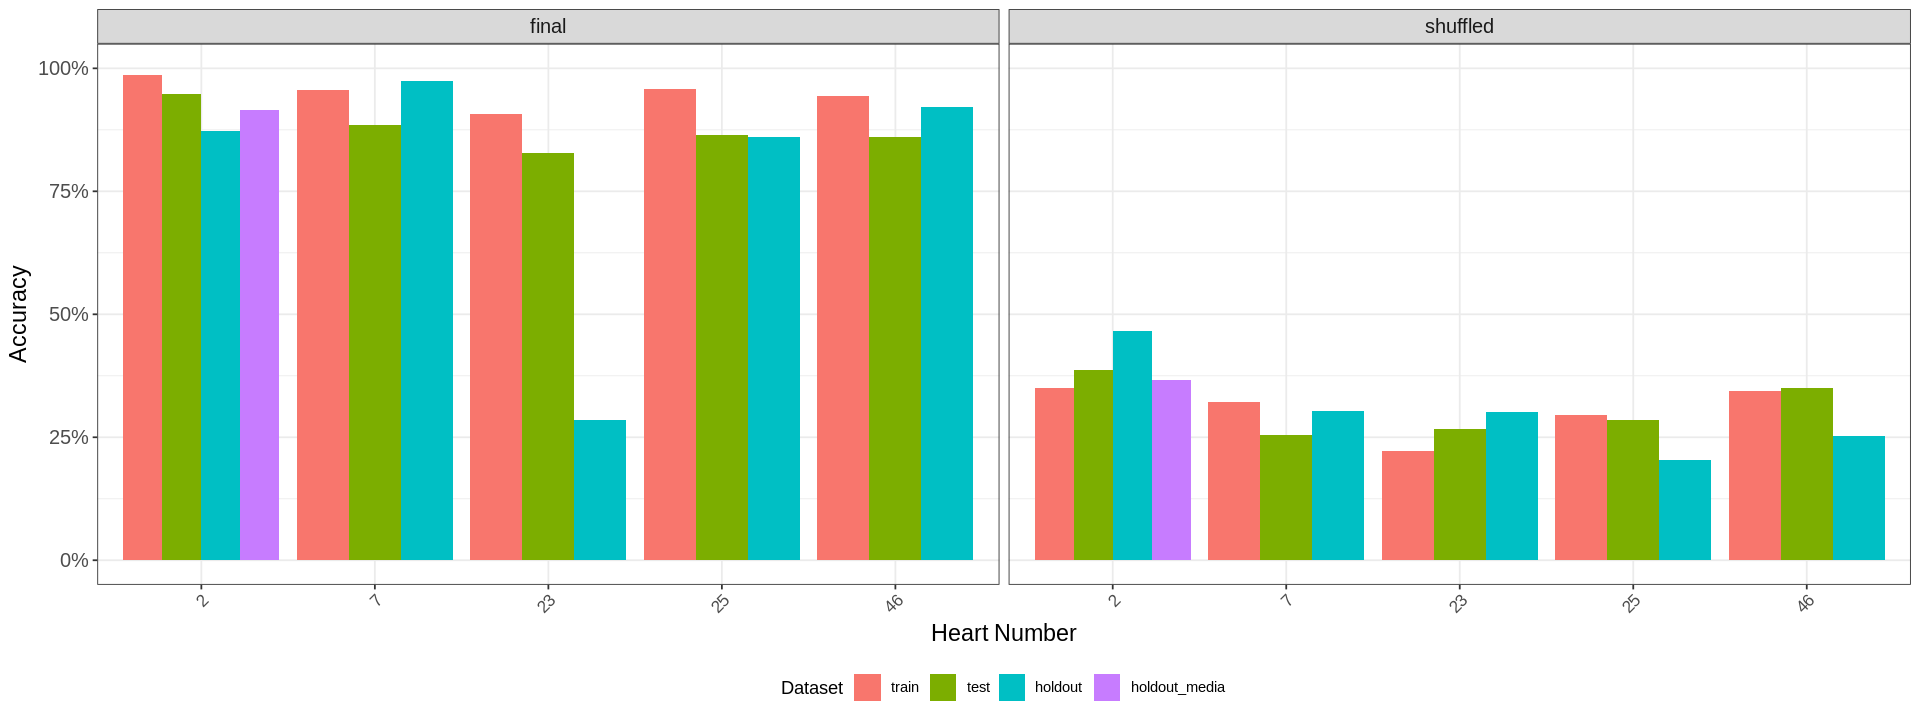

In [16]:
# Ensure desired order for dataset_modified
multi_class_accuracy_results <- multi_class_accuracy_results %>%
    mutate(dataset_modified = factor(dataset_modified, levels = c("train", "test", "holdout", "holdout_media")))

# Plot accuracy per heart
height <- 6
width <- 16
options(repr.plot.width = width, repr.plot.height = height)

accuracy_barplot <- ggplot(
        multi_class_accuracy_results,
        aes(x = factor(heart_number), y = accuracy, fill = dataset_modified)
) +
        geom_col(position = "dodge") +
        facet_wrap(model_type ~ .) +
        scale_y_continuous(labels = scales::percent_format(accuracy = 1), limits = c(0, 1)) +
        labs(
                x = "Heart Number",
                y = "Accuracy",
                fill = "Dataset"
        ) +
        theme_bw() +
        theme(
                axis.text.x = element_text(angle = 45, hjust = 1, size = 10),
                axis.text.y = element_text(size = 12),
                axis.title = element_text(size = 14),
                strip.text = element_text(size = 12),
                legend.position = "bottom"
        )

# Save plot
ggsave(file.path(output_dir, "accuracy_per_heart_multiclass.png"), accuracy_barplot, dpi = 600, width = width, height = height)

accuracy_barplot
